In [2]:
import torch
import torch.nn as nn
from torch.nn.functional import l1_loss
import torch.distributions as dist

import matplotlib.pyplot as plt
import numpy as np
import math

In [3]:
## merge
# 1. calculate rho over the entire dataset seen so far
def calculate_rho(data, w, phi, sigma):
    h=torch.vstack([dist.MultivariateNormal(_phi, sigma).log_prob(data) for _phi in phi])
    log_weights = torch.log(w) + h.T # Compute log of weights * likelihood
    log_rho = log_weights - torch.logsumexp(log_weights, dim=1, keepdim=True)  # Normalize
    return torch.exp(log_rho).squeeze()

# 2. calculate cluster similarity
def calculate_cluster_similarity(rho, K):
    ## TODO: make similarity metric an arg?
    return (
        torch.tensor(
            [l1_loss(rho[:,i], rho[:,j], reduction='mean') if j > i else 0. 
            for i in range(K) for j in range(K)]
        )
        .view(K, K)
    )

# 3. identify those clusters to merge
def get_clusters_to_merge(cluster_similarity_matrix, similarity_threshold):
    mask = (cluster_similarity_matrix > 0) & (cluster_similarity_matrix < similarity_threshold)
    to_merge = torch.nonzero(mask, as_tuple=False)
    values_to_merge = cluster_similarity_matrix[mask]
    order = torch.argsort(values_to_merge, descending=False) # order clusters in order of most similar
    return to_merge[order]

# 4. calculate merge statistics
def get_merge_statistics(clusters_to_merge, phi, rho, K):
    merged = []
    all_to_prune = []
    merge_statistics = dict()

    for m in clusters_to_merge:
        if (m[0] not in merged) and (m[1] not in merged):
            all_to_prune.append(m[0].item()) # prune first idx
            # use second idx as update
            merge_statistics[m[1].item()] = {
                'phi': (phi[m[0]] + phi[m[1]]) / 2,
                'rho': rho[m[0]] + rho[m[1]]
            }
            merged.append(m[0])
            merged.append(m[1])
    
    # convert to boolean tensor
    all_to_prune = torch.tensor([i in all_to_prune for i in range(K)])
    return merge_statistics, all_to_prune

## apply merge, then apply prune
def apply_merge(merge_statistics, phi, w):
    phi = phi.detach() ## remove from computation graph temporarily
    for k, v in merge_statistics.items():
        phi[k] = v['phi']
        w[k] = v['rho']
    phi = phi.requires_grad_(True) # reattach to graph
    return phi, w

def prune(prune_idx: torch.Tensor, w: torch.Tensor, phi: torch.Tensor):
    w = w[~prune_idx]
    phi = phi[~prune_idx]
    K = w.size(0)
    return w, phi, K

def merge_and_prune(data, w, phi, rho, sigma, K, similarity_threshold):
    rho_prime = calculate_rho(data, w, phi, sigma)
    cluster_similarity_matrix = calculate_cluster_similarity(rho_prime, K)
    clusters_to_merge = get_clusters_to_merge(cluster_similarity_matrix, similarity_threshold)
    merge_statistics, all_to_prune = get_merge_statistics(clusters_to_merge, phi, rho, K)
    phi, w = apply_merge(merge_statistics, phi, w)
    w, phi, K = prune(all_to_prune, w, phi)
    return w, phi, K

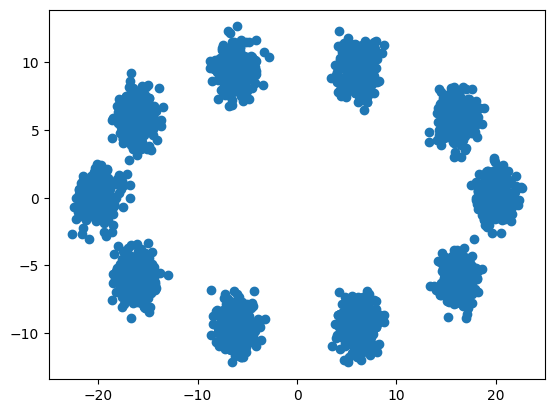

In [37]:

clusters = [
    dist.MultivariateNormal(
        torch.tensor([20*torch.cos(torch.tensor(i*math.pi/5)), 10*torch.sin(torch.tensor(i*math.pi/5))]),
        torch.diag(torch.ones(2,))
    ) for i in range(-5, 5)
]
N = 300
raw_data = torch.stack([
    d.sample(torch.tensor([N])) for d in clusters
]).reshape(-1, 2) 

data = raw_data.detach().numpy()
plt.scatter(
    data[:,0],
    data[:, 1]
)

In [35]:
n = raw_data.size(0)
lr = 1.0e-3
eps_new = .99

## pruning
eps_prune = .01
prune_freq = 100

## merging
eps_merge = .1
# merge_freq = 1000

K = 1
rho = torch.tensor([1.])
w = torch.tensor([1.])
alpha = torch.tensor([1.])
## set up base dist (mu of theta)
sigma = torch.diag(torch.ones(2,))
mu0 = torch.zeros((2,))
base_dist = dist.MultivariateNormal(mu0, 100*torch.diag(torch.ones(2,)))

## create first phi
phi = torch.nn.Parameter(raw_data[0,:]).unsqueeze(0)

## shuffle data
shuffdex = np.array(range(n))
np.random.shuffle(shuffdex)
data = raw_data[shuffdex,:]

for idx, i in enumerate(data[1:,:]):
    if (idx+1) % prune_freq == 0:
        to_prune = (w / w.sum()) < eps_prune
        w, phi, K = prune(to_prune, w, phi)
        print(f"Pruning, remaining clusters = {K} at obs {idx}...")

    # if (idx+1) % prune_freq == 0:
    #     to_prune = (w / w.sum()) < eps_prune
    #     prune_w = w[to_prune]
    #     prune_phi = phi[to_prune]
    #     print(
    #         f"Pruning at {idx + 1}...", 
    #         f"W:= {prune_w}",
    #         f"phi:= {prune_phi}",
    #         sep='\n'
    #     )
    #     w, phi, K = prune(to_prune, w, phi)
        # w, phi, K = merge_and_prune(data[:idx], w, phi, rho, sigma, K, eps_merge)
        # print(f"merged at {idx+1}: phi: {phi}, K: {K}")





    new_phi = torch.nn.Parameter(base_dist.sample())
    _phi = torch.vstack((phi, new_phi))
    _w = torch.concat((w, alpha))

    rho = calculate_rho(i, _w, _phi, sigma)



    if rho[K] > eps_new:
        # w is sum of rho across all previous obs
        w += rho[:K]
        w_next = torch.tensor([rho[K]])
        w = torch.concat((w, w_next))

        # add new params
        phi = torch.vstack((phi, new_phi))
        K += 1
        print(f"Increasing clusters to {K} at obs {idx}, located at: {new_phi}...")

    else:
        # renormalise to exclude K+1
        rho = rho[:K] / rho[:K].sum()

        # w is sum of rho across all previous obs
        w += rho[:K]

    d = np.min([1000, (idx+1)**.91])
    to_update = (base_dist.log_prob(phi) + d*rho.detach()*( dist.MultivariateNormal(phi, sigma).log_prob(i))).mean()
    # to_update = (rho.detach()*( dist.MultivariateNormal(phi, sigma).log_prob(i))).mean()
    

    grad_phi = torch.autograd.grad(to_update, phi,  retain_graph=True)[0]  # Compute gradient manually
    phi = phi + 1/d * grad_phi  # Apply gradient update
    phi = phi.detach().requires_grad_(True)  # Detach to prevent old computation graph accumulation


Increasing clusters to 2 at obs 2, located at: Parameter containing:
tensor([0.6564, 9.5308], requires_grad=True)...
Increasing clusters to 3 at obs 8, located at: Parameter containing:
tensor([-12.0903,   6.0581], requires_grad=True)...
Increasing clusters to 4 at obs 10, located at: Parameter containing:
tensor([12.1109, -1.9634], requires_grad=True)...
Increasing clusters to 5 at obs 16, located at: Parameter containing:
tensor([-1.0573, 21.3225], requires_grad=True)...
Increasing clusters to 6 at obs 52, located at: Parameter containing:
tensor([7.6062, 6.0410], requires_grad=True)...
Increasing clusters to 7 at obs 71, located at: Parameter containing:
tensor([-17.3339,  -8.7661], requires_grad=True)...
Pruning, remaining clusters = 7 at obs 99...
Increasing clusters to 8 at obs 102, located at: Parameter containing:
tensor([11.4291, -6.5009], requires_grad=True)...
Pruning, remaining clusters = 7 at obs 199...
Increasing clusters to 8 at obs 230, located at: Parameter containing:

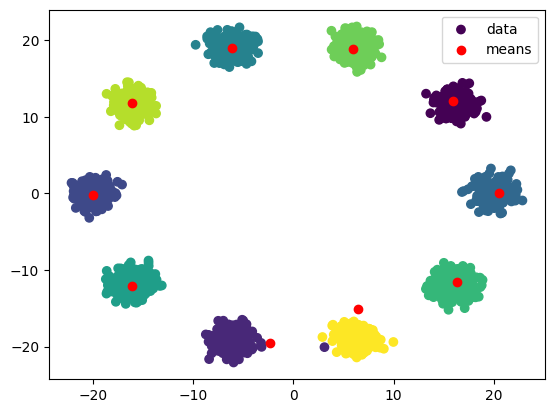

In [36]:
phi_np = phi.detach().numpy()

clusters = torch.argmax(
    torch.exp(dist.MultivariateNormal(phi, sigma).log_prob(data.unsqueeze(1)) ), 
    axis=1).detach().numpy()

k = data.detach().numpy()

probs = (w / w.sum()).detach().numpy()
plt.scatter(
    k[:,0], k[:,1],
    label='data',
    c = clusters
)
plt.scatter(
    phi_np[:,0],
    phi_np[:,1],
    label='means',
    c='red',
    # alpha = probs
)

plt.legend()

In [9]:
1/(300*10)**.6

0.008198364952831213

In [11]:
1/100000

1e-05

In [ ]:
def prune(prune_idx: torch.Tensor, w: torch.Tensor, phi: torch.Tensor):
    w = w[~prune_idx]
    phi = phi[~prune_idx]
    K = w.size(0)
    return w, phi, K

tensor([0.1634, 0.0581, 0.1425, 0.0745, 0.0103, 0.1679, 0.0855, 0.1489, 0.1488],
       grad_fn=<DivBackward0>)

In [17]:
(w == torch.tensor([.2, .6])).all()

tensor(True)

In [19]:
w = torch.tensor(
    [.1, .1, .2, .6]
)
phi = torch.tensor(
    [
        [1,1],
        [2,2],
        [3,3],
        [4,4]
    ]
)
K = phi.size(0)
to_prune = w < .2

w, phi, K = prune(to_prune, w, phi)

assert K == 2
assert (w == torch.tensor([.2, .6])).all()
assert (phi == torch.tensor([[3,3],[4,4]])).all()

In [167]:
w / w.sum()

tensor([0.0910, 0.0945, 0.0032, 0.0012, 0.0760, 0.1535, 0.0866, 0.1242, 0.0840,
        0.1397, 0.1462], grad_fn=<DivBackward0>)

In [157]:
rho = calculate_rho(data=data[:100], w=w, phi=phi, sigma=sigma)

In [158]:
rho.size()

torch.Size([100, 18])

In [159]:
K = 3

rho_test = torch.tensor(
    [[0, 0, 1.],
    [1., 0, 0],
    [0, 0, 1.]
    ],
)
# rho_test = torch.cat((rho1, rho2, rho3), dim=0)


actual = calculate_cluster_similarity(rho, 18)

In [161]:
actual.size()

torch.Size([18, 18])

In [155]:
l1_loss(rho_test[1,:], rho_test[0,:], reduction='mean')

tensor(0.6667)

In [131]:
rho_test = calculate_rho(data[:3], w, phi, sigma)
rho_test.size()

torch.Size([3, 18])

In [153]:
rho_test

tensor([[0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.]])

In [154]:
(
        torch.tensor(
            [l1_loss(rho_test[i,:], rho_test[j,:], reduction='mean') if j > i else 0. 
            for i in range(K) for j in range(K)]
        )
        .view(K, K)
    )

tensor([[0.0000, 0.6667, 0.0000],
        [0.0000, 0.0000, 0.6667],
        [0.0000, 0.0000, 0.0000]])

In [79]:
rho_test.size(), rho.size()

(torch.Size([9, 3]), torch.Size([100, 9]))

In [83]:
l1_loss(rho1, rho3, reduction='mean')

tensor(0.6667)

In [44]:
actual

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])